In [1]:
# importing libraries
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt 
%matplotlib inline
import pandas as pd
from datetime import date, timedelta
from pandas import DataFrame
import sqlalchemy as sq
import numpy as np
from sklearn.model_selection import train_test_split
import math
import time
import scipy as scipy
from scipy import stats
import seaborn as sns
from sklearn import linear_model, metrics, preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from ggplot import *
import statsmodels.api as sm
import xgboost as xgb
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import gc

Using Theano backend.


In [7]:
data=pd.read_csv('/data/pratik/returns/PriorEORS_Data.csv',error_bad_lines=False)

In [8]:
data.drop('id',axis=1,inplace=True)
data.columns

Index([u'def', u'jan16', u'jul16', u'orders', u'quantity', u'rev', u'gmv',
       u'ret_qty_perc', u'ret_val_perc', u'online_order', u'ats', u'sc',
       u'brands', u'avg_disc_perc', u'disc_10_30', u'disc_30_50',
       u'disc_50_70', u'sp_0_400', u'sp_400_800', u'sp_800_1200',
       u'sp_1200_plus', u'asp', u'avg_order_value', u'max_purchase_sequence',
       u'android_order', u'ios_order', u'app_order', u'web_order', u'cd_order',
       u'pp_order', u'mp_share', u'mfb_share', u'prem_perc', u'working_order',
       u'weekend_order', u'women_prod_perc', u'bsize_1', u'bsize_2_3',
       u'avg_items_per_at', u'avg_at_perorder', u'avg_sc_perorder',
       u'avg_order_gap', u'sessions', u'atc', u'atl', u'pdp', u'lp',
       u'atc_per_session', u'pdp_lp_ratio', u'org_session_prop', u'searches',
       u'days_since_install', u'source_of_install', u'e_order_share',
       u'e_quantity_share', u'e_rev_share', u'e_gmv_share', u'e_bsize_ratio',
       u'e_ret_qty_share', u'e_ret_val_share', u'

In [23]:
Y = data['def'].as_matrix()
X = data.drop(['def','source_of_install'],axis=1).as_matrix()

In [22]:
a=pd.DataFrame(data.dtypes,columns=['type'])
a[a['type']=='object']

type
source_of_install  object

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

In [25]:
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [26]:
predicted = model.predict(X_test)
probs = model.predict_proba(X_test)

In [27]:
print metrics.accuracy_score(y_test, predicted)
print metrics.roc_auc_score(y_test, probs[:, 1])

0.70187312246
0.73249185863


In [28]:
print metrics.classification_report(y_test, predicted)
cm=pd.DataFrame(metrics.confusion_matrix(y_test, predicted))
cm

             precision    recall  f1-score   support

          0       0.96      0.71      0.81     52386
          1       0.15      0.64      0.24      4204

avg / total       0.90      0.70      0.77     56590



0      1
0  37015  15371
1   1500   2704

In [36]:
X_train.shape

(132041, 62)

In [37]:
def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(62, input_dim=62, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [40]:
estimator = KerasClassifier(build_fn=create_baseline, nb_epoch=100, batch_size=5000, verbose=0)

In [34]:
seed = 7
np.random.seed(seed)

In [41]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Results: 92.49% (0.00%)


In [82]:
# evaluate baseline model with standardized dataset
np.random.seed(seed)
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_baseline, epochs=10, batch_size=5000, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(pipeline, X_train, y_train, cv=kfold)
print("Standardized: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Standardized: 92.49% (0.02%)


In [324]:
def create_4layer(optimizer='adam', init='glorot_uniform'):
    # create model
    model = Sequential()
    model.add(Dense(62, input_dim=62, kernel_initializer='normal', activation='relu'))
    model.add(Dense(30, kernel_initializer='normal', activation='relu'))
    model.add(Dense(10, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [323]:
def create_3layer(optimizer='adam', init='glorot_uniform'):
    # create model
    model = Sequential()
    model.add(Dense(62, input_dim=62, kernel_initializer='normal', activation='relu'))
    model.add(Dense(20, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [257]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weight

array([ 0.54061988,  6.65462151])

In [259]:
class_weight={0:0.54,1:6.65}

In [359]:
model=KerasClassifier(build_fn=create_4layer, epochs=15, batch_size=1000, verbose=0)

In [321]:
optimizers = ['rmsprop', 'adam']
init = ['glorot_uniform', 'normal', 'uniform']
epochs = [10, 20, 30]
batches = [500, 1000, 2000]
param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batches, init=init)
grid = GridSearchCV(estimator=model, param_grid=param_grid,n_jobs=10)
grid_result = grid.fit(X_train, y_train,class_weight=class_weight)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.924932 using {'epochs': 30, 'init': 'uniform', 'optimizer': 'adam', 'batch_size': 500}
0.924864 (0.002385) with: {'epochs': 10, 'init': 'glorot_uniform', 'optimizer': 'rmsprop', 'batch_size': 500}
0.924811 (0.002365) with: {'epochs': 10, 'init': 'glorot_uniform', 'optimizer': 'adam', 'batch_size': 500}
0.924864 (0.002385) with: {'epochs': 10, 'init': 'normal', 'optimizer': 'rmsprop', 'batch_size': 500}
0.924864 (0.002385) with: {'epochs': 10, 'init': 'normal', 'optimizer': 'adam', 'batch_size': 500}
0.924864 (0.002385) with: {'epochs': 10, 'init': 'uniform', 'optimizer': 'rmsprop', 'batch_size': 500}
0.924864 (0.002385) with: {'epochs': 10, 'init': 'uniform', 'optimizer': 'adam', 'batch_size': 500}
0.924864 (0.002385) with: {'epochs': 20, 'init': 'glorot_uniform', 'optimizer': 'rmsprop', 'batch_size': 500}
0.924864 (0.002385) with: {'epochs': 20, 'init': 'glorot_uniform', 'optimizer': 'adam', 'batch_size': 500}
0.924864 (0.002385) with: {'epochs': 20, 'init': 'normal', 'optimiz

In [360]:
model.fit(X_train, y_train,class_weight=class_weight,validation_split=0.1)
predicted = model.predict(X_test).astype('int')
probs = model.predict_proba(X_test)

In [361]:
print metrics.accuracy_score(y_test, predicted)
print metrics.roc_auc_score(y_test, probs[:, 1])

0.676356246687
0.741888316919


In [362]:
print metrics.classification_report(y_test, predicted)
cm=pd.DataFrame(metrics.confusion_matrix(y_test, predicted))
cm

             precision    recall  f1-score   support

          0       0.96      0.68      0.79     52386
          1       0.14      0.68      0.24      4204

avg / total       0.90      0.68      0.75     56590



0      1
0  35409  16977
1   1338   2866

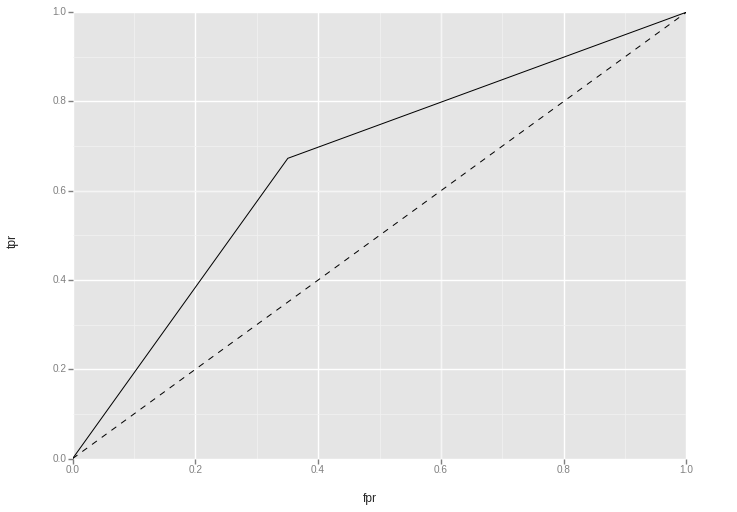

<ggplot: (8763176948841)>

In [355]:
fpr, tpr, _ = metrics.roc_curve(y_test, predicted)

df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
ggplot(df, aes(x='fpr', y='tpr')) +\
    geom_line() +\
    geom_abline(linetype='dashed')

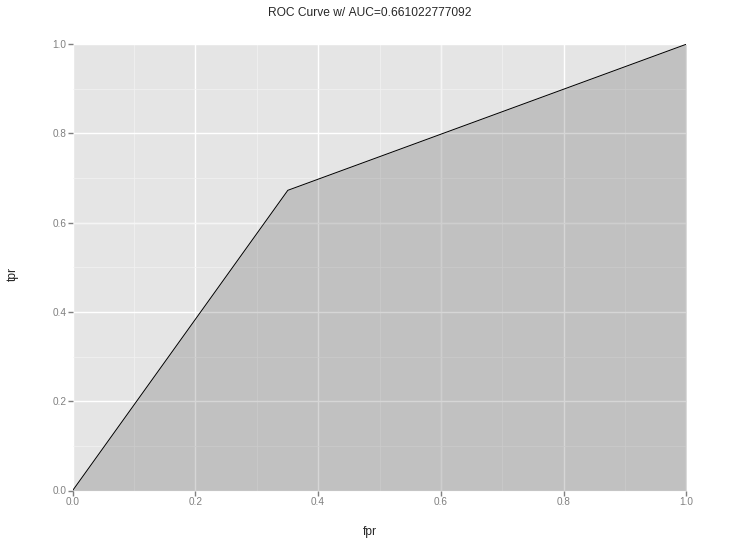

<ggplot: (8763182147173)>

In [356]:
auc = metrics.auc(fpr,tpr)
ggplot(df, aes(x='fpr', y='tpr')) +\
    geom_area(alpha=0.2) +\
    geom_line(aes(y='tpr')) +\
    ggtitle("ROC Curve w/ AUC=%s" % str(auc))

In [357]:
p=pd.DataFrame(probs[:, 1],columns=['Probs'])
p['0.1']=0
p['0.1'][p['Probs']>0.1]=1
p['0.2']=0
p['0.2'][p['Probs']>0.2]=1
p['0.3']=0
p['0.3'][p['Probs']>0.3]=1
p['0.4']=0
p['0.4'][p['Probs']>0.4]=1
p['0.5']=0
p['0.5'][p['Probs']>0.5]=1
p['0.6']=0
p['0.6'][p['Probs']>0.6]=1
p['0.7']=0
p['0.7'][p['Probs']>0.7]=1
p['0.8']=0
p['0.8'][p['Probs']>0.8]=1
p['0.9']=0
p['0.9'][p['Probs']>0.9]=1

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

In [358]:
pred={}
pr=p.ix[:,1:10].columns
for i in pr:
    pred[i]=p[i]
cm={}
for i in pr:
    print i
    print metrics.classification_report(y_test, pred[i])
    cm[i]=pd.DataFrame(metrics.confusion_matrix(y_test, pred[i]))
    cm[i]['p']=i
final = pd.DataFrame()
for i in pr: 
    final=final.append(cm[i])
final

0.1
             precision    recall  f1-score   support

          0       0.00      0.00      0.00     52386
          1       0.07      1.00      0.14      4204

avg / total       0.01      0.07      0.01     56590

0.2
             precision    recall  f1-score   support

          0       0.99      0.01      0.02     52386
          1       0.07      1.00      0.14      4204

avg / total       0.92      0.08      0.03     56590

0.3
             precision    recall  f1-score   support

          0       0.98      0.16      0.28     52386
          1       0.08      0.95      0.15      4204

avg / total       0.91      0.22      0.27     56590

0.4
             precision    recall  f1-score   support

          0       0.97      0.42      0.59     52386
          1       0.10      0.84      0.18      4204

avg / total       0.91      0.45      0.56     56590

0.5
             precision    recall  f1-score   support

          0       0.96      0.65      0.78     52386
          1  

0      1    p
0      0  52386  0.1
1      0   4204  0.1
0    438  51948  0.2
1      6   4198  0.2
0   8508  43878  0.3
1    203   4001  0.3
0  22084  30302  0.4
1    690   3514  0.4
0  34017  18369  0.5
1   1376   2828  0.5
0  43740   8646  0.6
1   2302   1902  0.6
0  49647   2739  0.7
1   3288    916  0.7
0  51957    429  0.8
1   3954    250  0.8
0  52376     10  0.9
1   4185     19  0.9

In [294]:
mlp = MLPClassifier(activation='logistic',solver='lbfgs',alpha=0.01,learning_rate='adaptive',batch_size=5000,verbose=False,hidden_layer_sizes=(40), random_state=1)


In [295]:
mlp.fit(X_train, y_train)

MLPClassifier(activation='logistic', alpha=0.01, batch_size=5000, beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=40, learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [299]:
predicted_mlp = mlp.predict(X_test).astype('int')
probs_mlp = mlp.predict_proba(X_test)

In [305]:
print metrics.accuracy_score(y_test, predicted_mlp)
print metrics.roc_auc_score(y_test, probs_mlp[:, 1])

0.925711256406
0.583561210237


In [307]:
print metrics.classification_report(y_test, predicted_mlp)
cm=pd.DataFrame(metrics.confusion_matrix(y_test, predicted_mlp))
cm

             precision    recall  f1-score   support

          0       0.93      1.00      0.96     52386
          1       0.00      0.00      0.00      4204

avg / total       0.86      0.93      0.89     56590



0  1
0  52386  0
1   4204  0

In [308]:
probs_mlp

array([[ 0.9422777 ,  0.0577223 ],
       [ 0.92205248,  0.07794752],
       [ 0.92204531,  0.07795469],
       ..., 
       [ 0.94245861,  0.05754139],
       [ 0.93151314,  0.06848686],
       [ 0.93150433,  0.06849567]])